**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/SBK.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High   Low  Close   Volume  Earnings Yield (EY)  \
0 1999-01-01  1800  1810  1720   1800        0                  9.5   
1 1999-01-04  1800  1800  1760   1800   445151                  9.5   
2 1999-01-05  1800  1820  1785   1800   573997                  9.5   
3 1999-01-06  1820  1990  1820   1950  2526593                  8.8   
4 1999-01-07  1950  2025  1775   1840  1751973                  9.3   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  2.9        10.526316      -           -   
1                  2.9        10.526316      -           -   
2                  2.9        10.526316      -           -   
3                  2.7        11.363636      -           -   
4                  2.8        10.752688      -           -   

   Total Return Index (TRI)  
0                     186.0  
1                     186.0  
2                     186.0  
3                     201.0  
4                     190.0

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11  0.066249 -0.066249  0.027780  0.009174 -0.022574 -0.027029   
2000-05-12 -0.002270 -0.020203  0.006826  0.034606  0.016000 -0.015748   
2000-05-15 -0.006889 -0.024860 -0.009112 -0.002286  0.025494  0.006889   
2000-05-16 -0.006689  0.036203  0.029314  0.020203  0.027029  0.054808   
2000-05-17 -0.030908  0.076787  0.021979  0.051293  0.042182  0.049008   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11 -0.099849 -0.083141 -0.055558  -0.064078  ...     -0.098293   
2000-05-12 -0.082817 -0.062162 -0.061661  -0.056101  ...     -0.061967   
2000-05-15 -0.065826 -0.049728 -0.068229  -0.050420  ...     -0.022473   
2000-05-16 -0.035953 -0.021084 -0.062976  -0.034671  ...     -0.020294   
2000-05-17  0.000336  0.011540 -0.049746  -0.014406  ...      0.036203   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11    -0.082238     -0.065958          -0.065958         -0.035718   
2000-05-12    -0.022990     -0.048361          -0.048361          0.009050   
2000-05-15    -0.031893     -0.044452          -0.022473         -0.013544   
2000-05-16     0.018391      0.000000           0.008889          0.047574   
2000-05-17     0.081726      0.048468           0.068993          0.123444   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11           -0.061694           -0.070514          -0.040274   
2000-05-12           -0.013423           -0.055141           0.002270   
2000-05-15           -0.018019           -0.029314          -0.020386   
2000-05-16            0.040638            0.004454           0.043139   
2000-05-17            0.087598            0.058182           0.112633   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11           -0.070514         -0.068053  
2000-05-12           -0.055141         -0.004556  
2000-05-15           -0.051293         -0.013544  
2000-05-16           -0.004435          0.018391  
2000-05-17            0.037657          0.090654  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.0032413268041956303
  dropout = 0.05198541571704722
  units = 112
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 9
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0005840990668899395
RMSE = 0.02416814156880788
MAE = 0.01808879381446094
R-Squared = 0.5939088511064854

Results on Validation set: 
MSE = 0.0015060917128279802
RMSE = 0.038808397452458405
MAE = 0.031080169334172788
R-Squared = 0.019111372056014098

Results on Testing set: 
MSE = 0.001090118314221479
RMSE = 0.03301693980703661
MAE = 0.026142834932577012
R-Squared = -0.22869328786953336



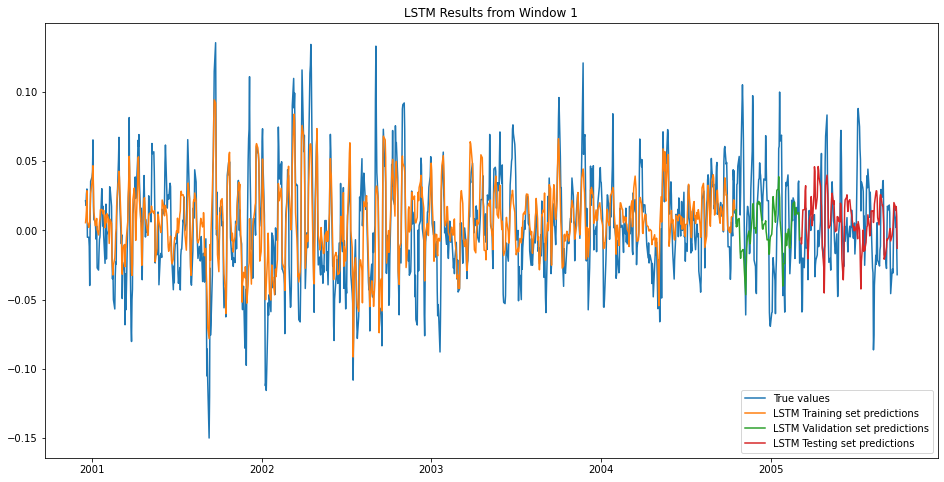

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0014024412855003555
RMSE = 0.03744918270804258
MAE = 0.028750877610538877
R-Squared = 0.06101705108057942

Results on Validation set: 
MSE = 0.0009383583559567528
RMSE = 0.030632635471939937
MAE = 0.02342028749682387
R-Squared = -0.011971245866217783

Results on Testing set: 
MSE = 0.001185425353671118
RMSE = 0.0344300065883107
MAE = 0.02921108688153558
R-Squared = 0.012089268198822056



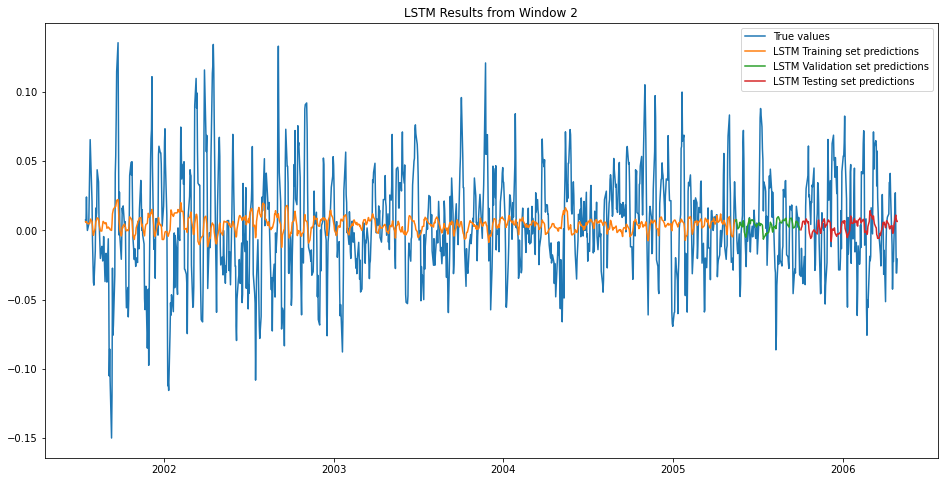

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0012031947347034822
RMSE = 0.03468709752492247
MAE = 0.02718349283148887
R-Squared = 0.05659189210709914

Results on Validation set: 
MSE = 0.001129961709534555
RMSE = 0.03361490308679403
MAE = 0.02816186475825504
R-Squared = 0.13445748862177043

Results on Testing set: 
MSE = 0.0017851156218423232
RMSE = 0.042250628656178874
MAE = 0.03171014783294801
R-Squared = 0.1176218133788649



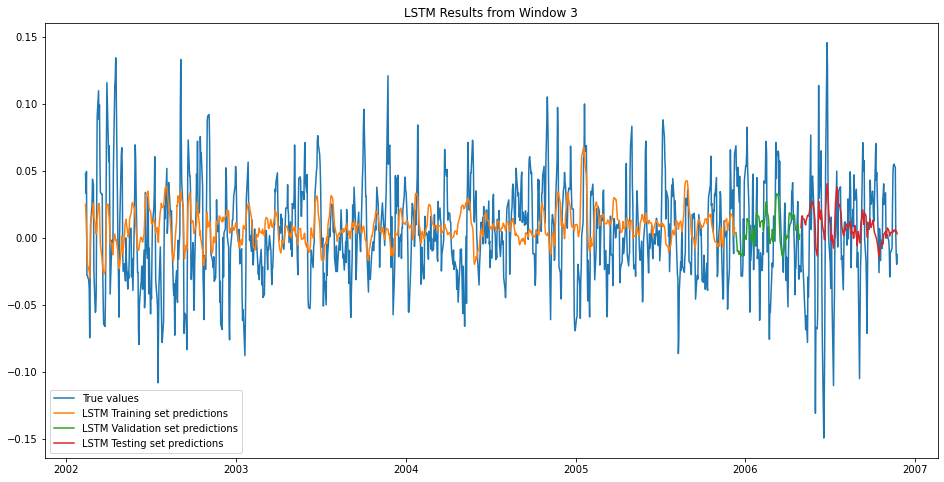

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0010262275872902466
RMSE = 0.032034787142889626
MAE = 0.025144488016327935
R-Squared = 0.16469400669670642

Results on Validation set: 
MSE = 0.0009269829072558577
RMSE = 0.03044639399429525
MAE = 0.024147993603993806
R-Squared = 0.15448128571500064

Results on Testing set: 
MSE = 0.0012092906020752003
RMSE = 0.0347748558886331
MAE = 0.028968283881943578
R-Squared = 0.0681576312315122



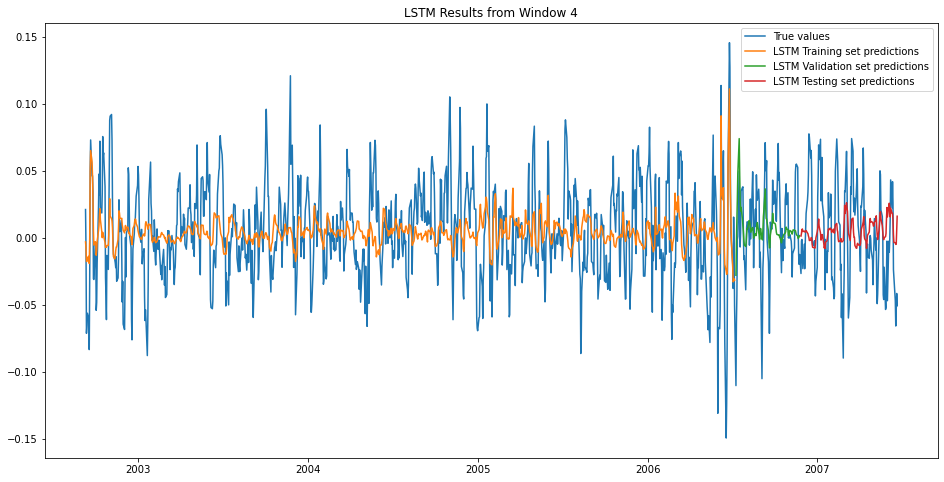

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0012007594057507366
RMSE = 0.034651975495644353
MAE = 0.02669881021560443
R-Squared = -0.018259419720653147

Results on Validation set: 
MSE = 0.0011995253392527267
RMSE = 0.03463416433599527
MAE = 0.02887259785775412
R-Squared = 0.10468266490919931

Results on Testing set: 
MSE = 0.002184050125828821
RMSE = 0.046733822075974284
MAE = 0.03945153597775893
R-Squared = -0.07972133016177163



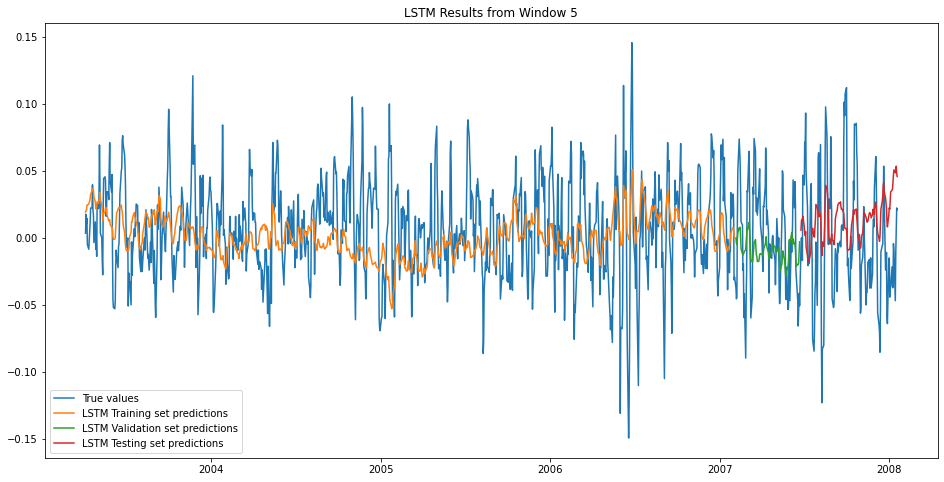

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0012121072443979212
RMSE = 0.034815330594407994
MAE = 0.027095246189196218
R-Squared = 0.07802327052095781

Results on Validation set: 
MSE = 0.0019886161185536555
RMSE = 0.044593902257524576
MAE = 0.03656896462740686
R-Squared = -0.184674382095815

Results on Testing set: 
MSE = 0.0026734692609656757
RMSE = 0.051705601833511965
MAE = 0.043240522204412
R-Squared = -0.5692568917583536



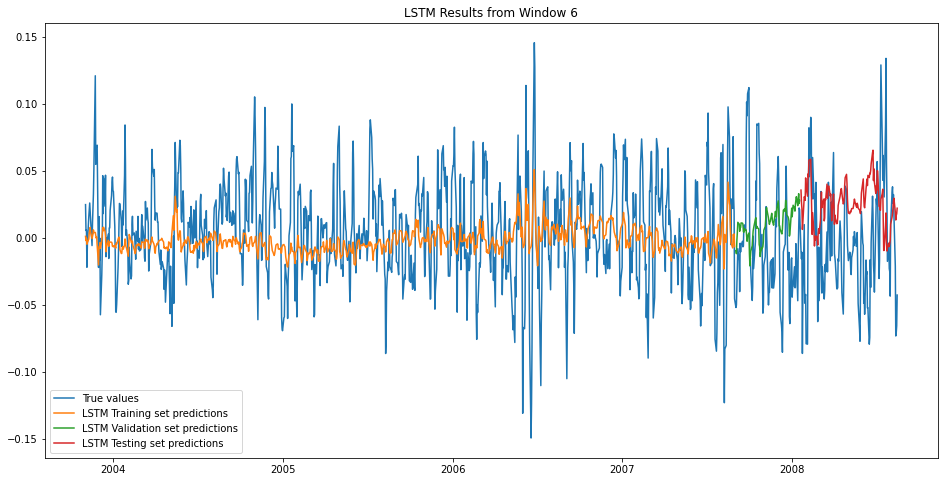

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.001271987711126592
RMSE = 0.0356649367183876
MAE = 0.028311543772282198
R-Squared = 0.10851097627280548

Results on Validation set: 
MSE = 0.0019819515856436903
RMSE = 0.044519114834458355
MAE = 0.03405236043827611
R-Squared = -0.16383703661003568

Results on Testing set: 
MSE = 0.005536476206848089
RMSE = 0.07440750101198192
MAE = 0.05748187587591495
R-Squared = -0.04610112881987316



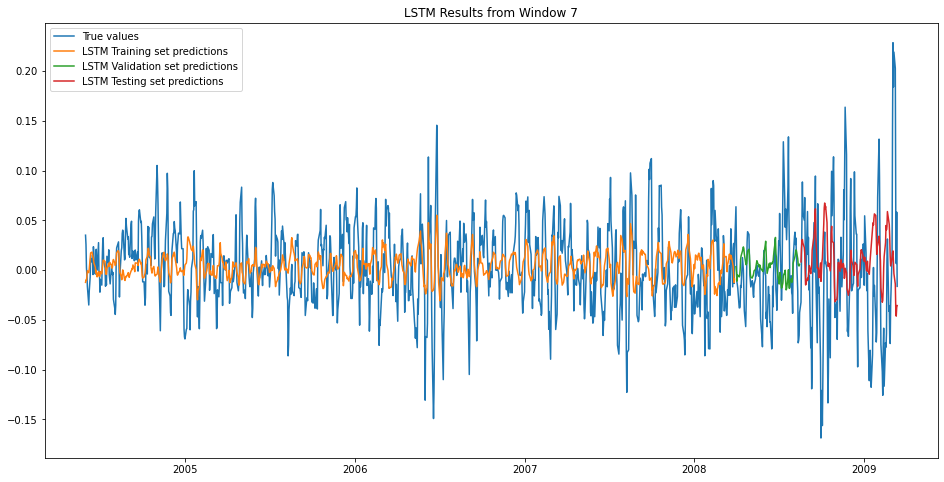

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0016156241785897304
RMSE = 0.040194827759174816
MAE = 0.030920751942437683
R-Squared = 0.050300295590100186

Results on Validation set: 
MSE = 0.005354147482920424
RMSE = 0.07317204030857978
MAE = 0.05537079213144188
R-Squared = 0.03102789508478787

Results on Testing set: 
MSE = 0.0018641577378511213
RMSE = 0.043175893017413335
MAE = 0.03383254653285719
R-Squared = -0.11614306348966497



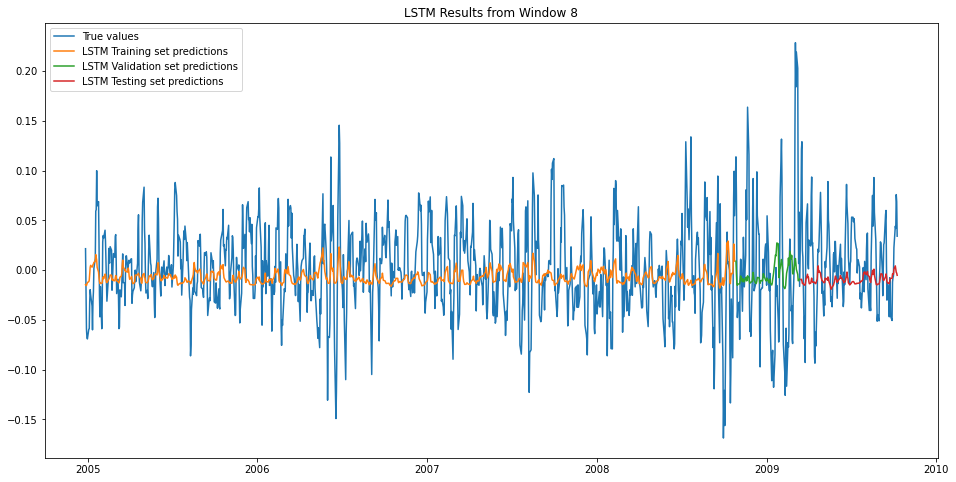

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0021542270979492254
RMSE = 0.04641365206433583
MAE = 0.03573168359139973
R-Squared = 0.031807655709490845

Results on Validation set: 
MSE = 0.001085314484104591
RMSE = 0.03294411152398242
MAE = 0.026806812711914728
R-Squared = 0.05171330643314265

Results on Testing set: 
MSE = 0.0006893202754438071
RMSE = 0.026254909549335854
MAE = 0.02046009636867178
R-Squared = 0.052332792581762266



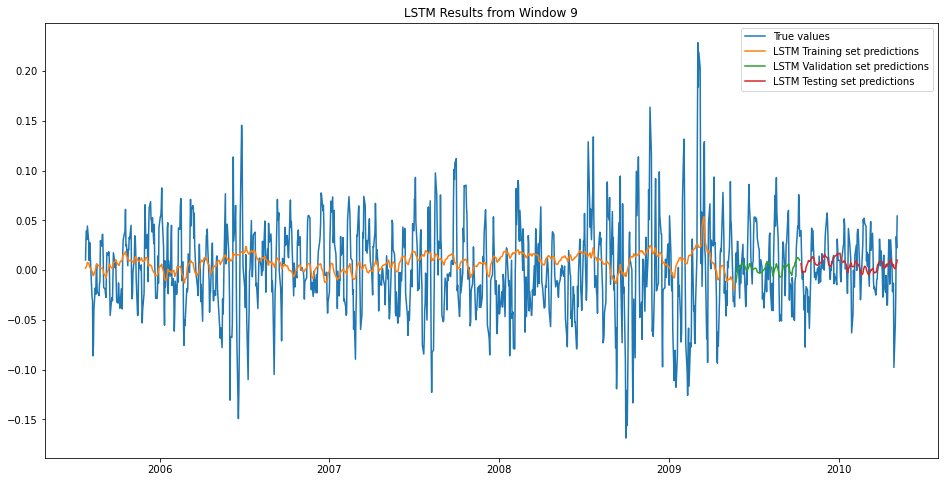

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.001324203581101005
RMSE = 0.03638960814712086
MAE = 0.0278525425837958
R-Squared = 0.40216468455485954

Results on Validation set: 
MSE = 0.0007333184263214694
RMSE = 0.027079852775106984
MAE = 0.02083368910223488
R-Squared = -0.0007463983224056392

Results on Testing set: 
MSE = 0.0012771113677535507
RMSE = 0.03573669497524289
MAE = 0.029585413328419522
R-Squared = -0.49231352410108764



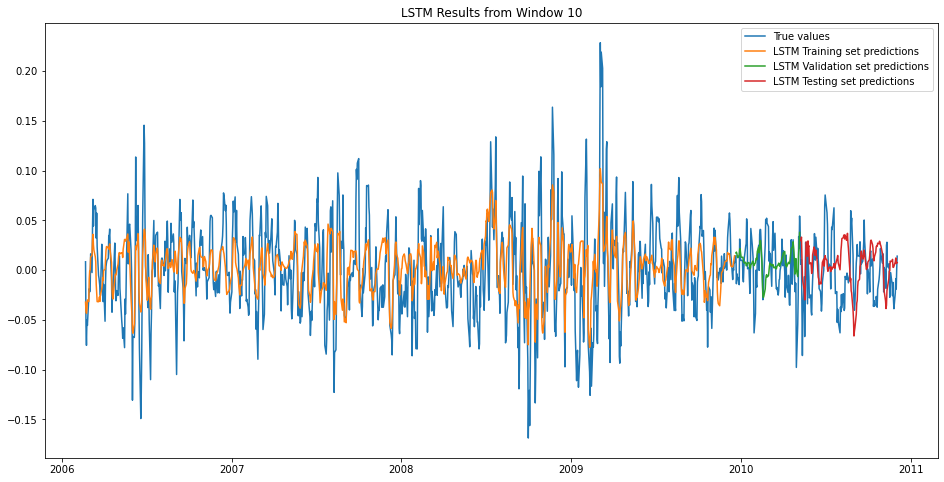

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.001966915207376391
RMSE = 0.04434991778319765
MAE = 0.03322115940694648
R-Squared = 0.030687145988756104

Results on Validation set: 
MSE = 0.0007663011066103652
RMSE = 0.02768214418375797
MAE = 0.021917768501404387
R-Squared = -0.11606411252683624

Results on Testing set: 
MSE = 0.0006529377025452646
RMSE = 0.02555264570539154
MAE = 0.02028504346717766
R-Squared = -0.18160486057718028



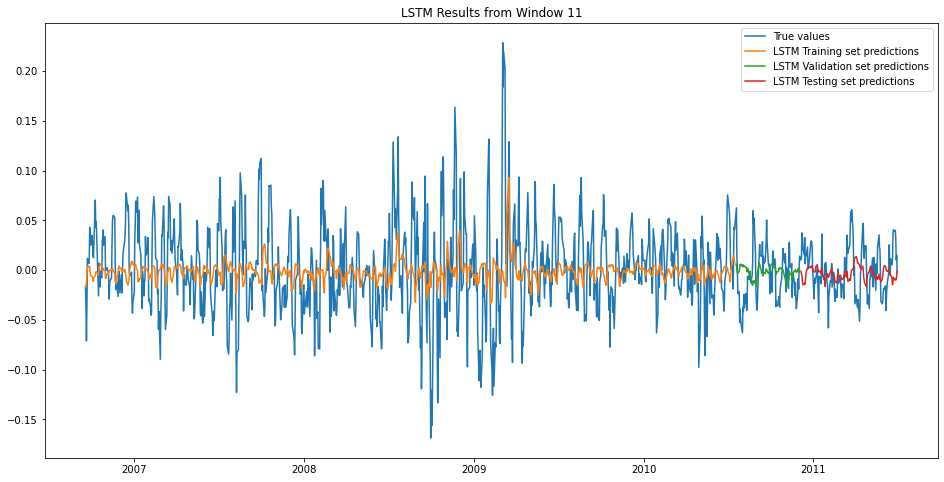

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.00179945108242158
RMSE = 0.04241993732222597
MAE = 0.03133512019056696
R-Squared = 0.06752667553917002

Results on Validation set: 
MSE = 0.0005955752251503382
RMSE = 0.02440440995292323
MAE = 0.020291491102841022
R-Squared = 0.04373469487794568

Results on Testing set: 
MSE = 0.0007455207484560411
RMSE = 0.027304225835134772
MAE = 0.02185033065870484
R-Squared = -0.001645084891806814



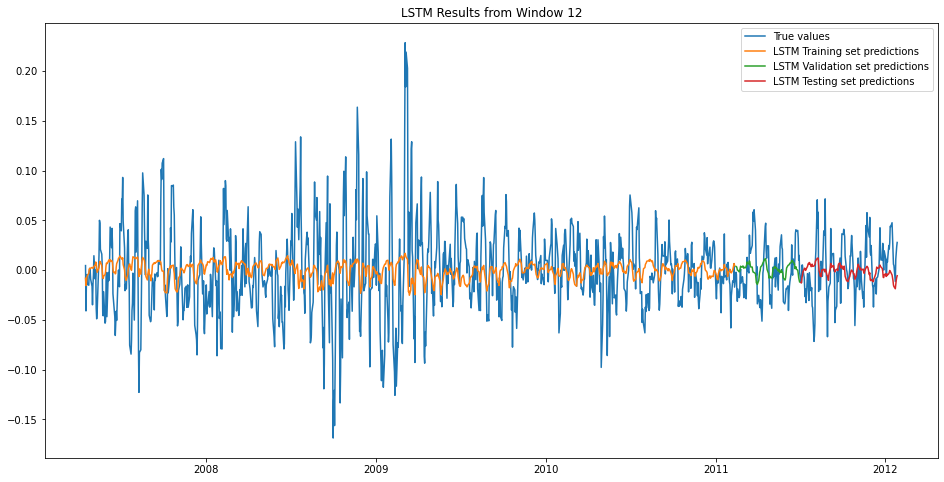

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.001536347648982225
RMSE = 0.039196270855557484
MAE = 0.029013621065507773
R-Squared = 0.12597756465411558

Results on Validation set: 
MSE = 0.0005790397331040909
RMSE = 0.024063244442595246
MAE = 0.01958456772892452
R-Squared = -0.0056668073601569

Results on Testing set: 
MSE = 0.00048190032935360987
RMSE = 0.021952228345970024
MAE = 0.016683590790420266
R-Squared = -0.015569544325987783



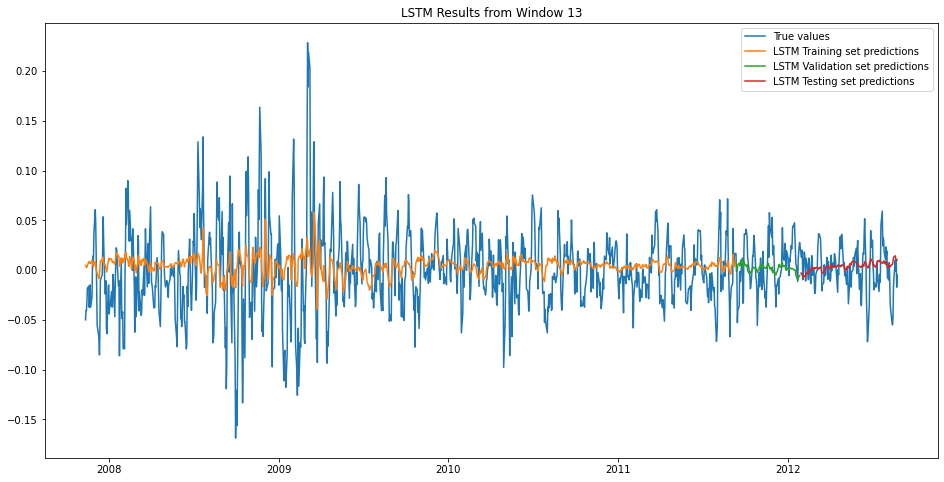

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0015405275263917883
RMSE = 0.039249554473799936
MAE = 0.02800055511102896
R-Squared = 0.05434392654836073

Results on Validation set: 
MSE = 0.0005338320554828382
RMSE = 0.023104805895805276
MAE = 0.018030215814074536
R-Squared = 0.11366344455821709

Results on Testing set: 
MSE = 0.0006531893785289326
RMSE = 0.02555756988700085
MAE = 0.018215255656854657
R-Squared = -0.18702013119962912



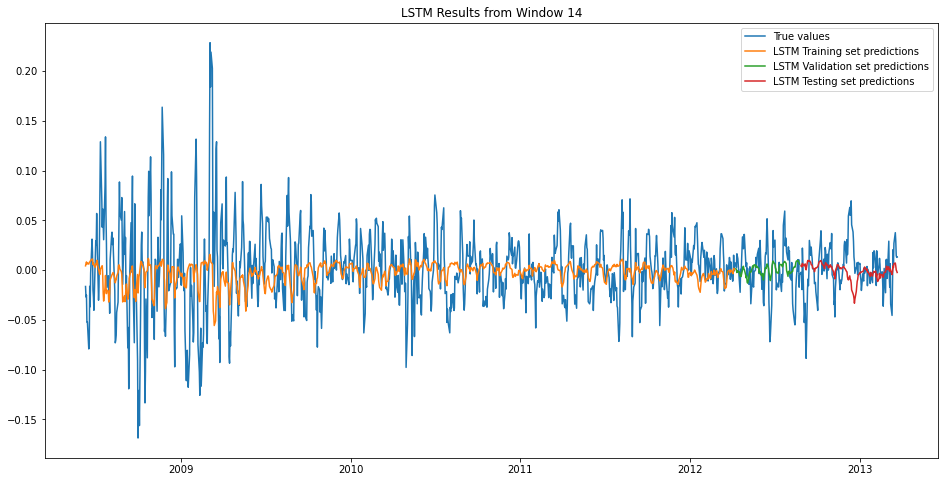

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0010960067321942192
RMSE = 0.03310599239101917
MAE = 0.023614260851535583
R-Squared = 0.08688485337827179

Results on Validation set: 
MSE = 0.0005347091876733809
RMSE = 0.023123779701281124
MAE = 0.01633860378726
R-Squared = -0.13760850449388662

Results on Testing set: 
MSE = 0.0006025777615810817
RMSE = 0.024547459371207475
MAE = 0.01877309620340339
R-Squared = -0.007094005471712794



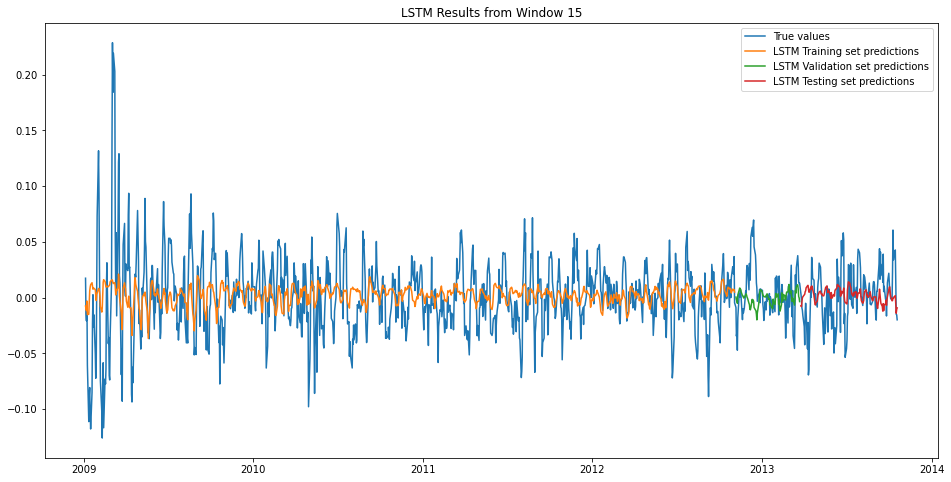

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0005961488832352414
RMSE = 0.024416160288531063
MAE = 0.018658128573493086
R-Squared = 0.14340462344160476

Results on Validation set: 
MSE = 0.0005628485425567261
RMSE = 0.023724429235636547
MAE = 0.01836912413992938
R-Squared = 0.009798156660543289

Results on Testing set: 
MSE = 0.0008937751046654553
RMSE = 0.0298960717263231
MAE = 0.022437788110112763
R-Squared = -0.10782408188699955



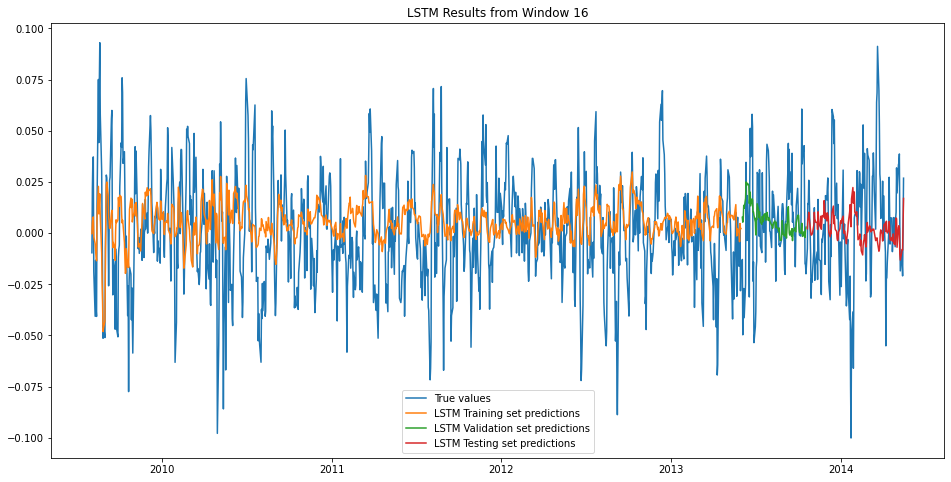

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.000607892221408447
RMSE = 0.024655470415476704
MAE = 0.019090399730987063
R-Squared = 0.04156001175634361

Results on Validation set: 
MSE = 0.0009206149032146535
RMSE = 0.03034163646237054
MAE = 0.02312033100811078
R-Squared = 0.029477384676682927

Results on Testing set: 
MSE = 0.0006118629276885925
RMSE = 0.024735863188669858
MAE = 0.019029864913895526
R-Squared = -0.054564310310589725



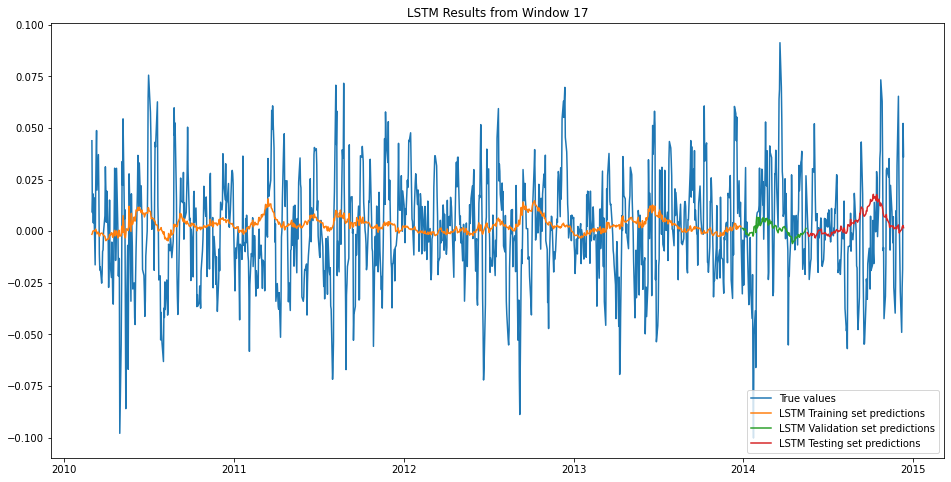

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0004601063391595166
RMSE = 0.021450089490711144
MAE = 0.016145915255504874
R-Squared = 0.22331613929254424

Results on Validation set: 
MSE = 0.0006538704409904517
RMSE = 0.02557089050053697
MAE = 0.021232764301642802
R-Squared = 0.12732543982735112

Results on Testing set: 
MSE = 0.0008636449705302721
RMSE = 0.029387837118955727
MAE = 0.023256373584020197
R-Squared = -0.032336368604427124



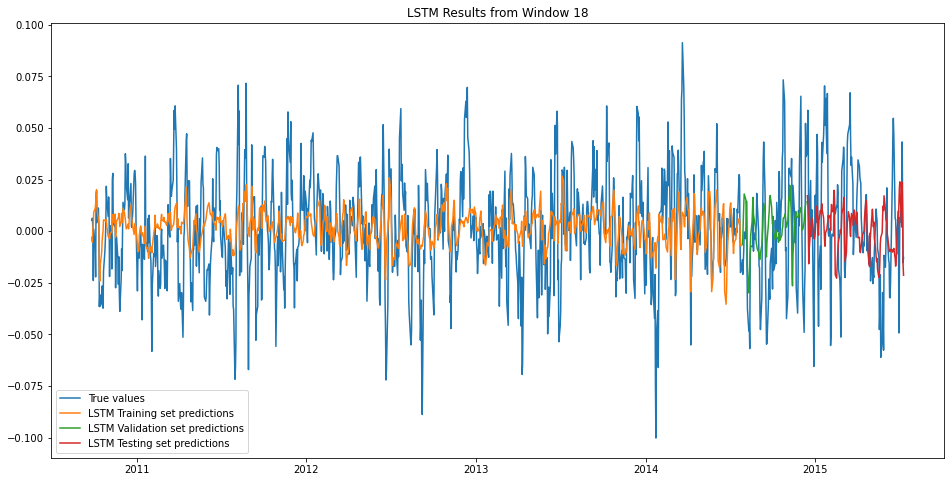

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0005775209684240224
RMSE = 0.024031665951906506
MAE = 0.01830290894423164
R-Squared = 0.10144615464431683

Results on Validation set: 
MSE = 0.0006874564718311615
RMSE = 0.02621939114150368
MAE = 0.020621137442616323
R-Squared = 0.0670564756657267

Results on Testing set: 
MSE = 0.003369866461042814
RMSE = 0.058050550910760654
MAE = 0.04320493517304407
R-Squared = -0.40883908149535997



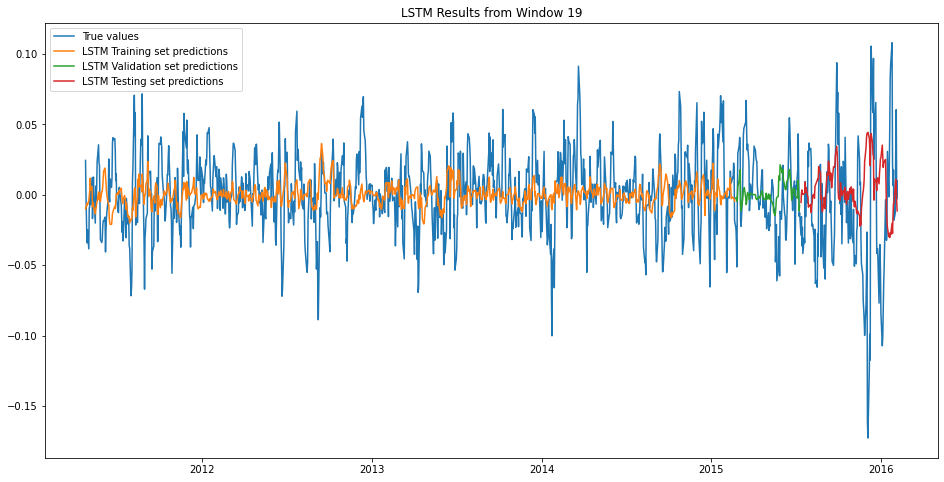

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0004767072357313762
RMSE = 0.021833626261603366
MAE = 0.01670463168252049
R-Squared = 0.28296182507304923

Results on Validation set: 
MSE = 0.0036011540847105013
RMSE = 0.060009616601928904
MAE = 0.046657224486590765
R-Squared = -0.13381749401750054

Results on Testing set: 
MSE = 0.003292589818789358
RMSE = 0.05738109286855173
MAE = 0.046430966508190306
R-Squared = -0.1350534842958775



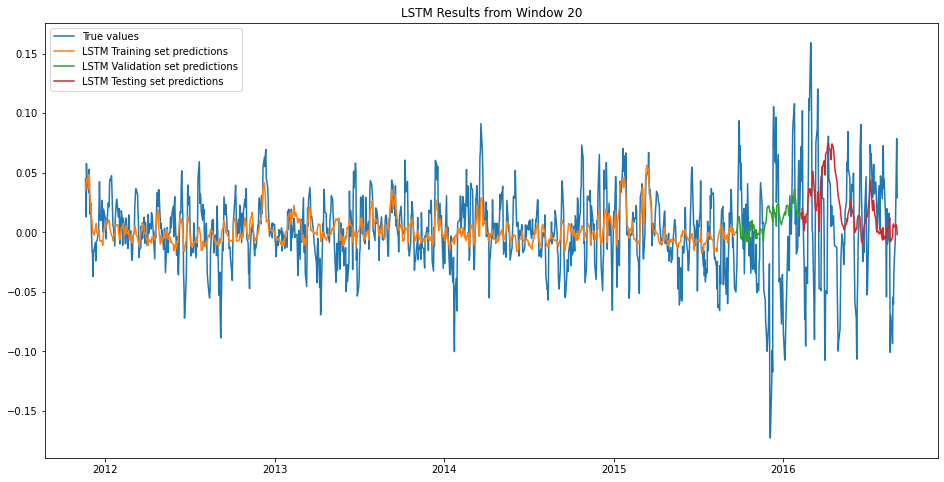

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.001019462509705842
RMSE = 0.03192902299955077
MAE = 0.02290301228446288
R-Squared = 0.12135659701794477

Results on Validation set: 
MSE = 0.002129186025039062
RMSE = 0.04614310376469123
MAE = 0.03784121435603883
R-Squared = 0.026386324509481418

Results on Testing set: 
MSE = 0.0012244702607353327
RMSE = 0.034992431477897226
MAE = 0.02700772365994038
R-Squared = 0.012315831404975719



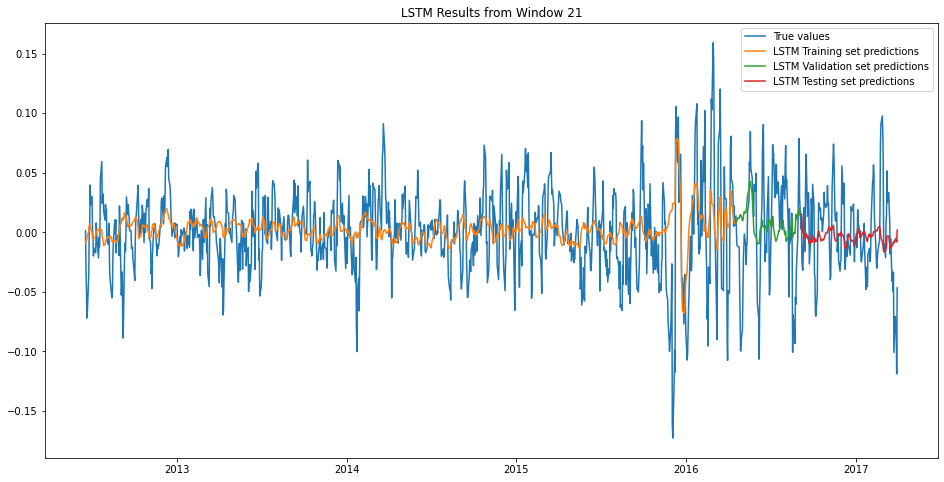

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0006803132009588346
RMSE = 0.026082814283716293
MAE = 0.019410011663456517
R-Squared = 0.4817598154338838

Results on Validation set: 
MSE = 0.001279524557483453
RMSE = 0.03577044251170865
MAE = 0.02670129590516551
R-Squared = 0.09971219473347204

Results on Testing set: 
MSE = 0.0010385076896408652
RMSE = 0.03222588539731477
MAE = 0.02646698061175543
R-Squared = -0.12336051373490675



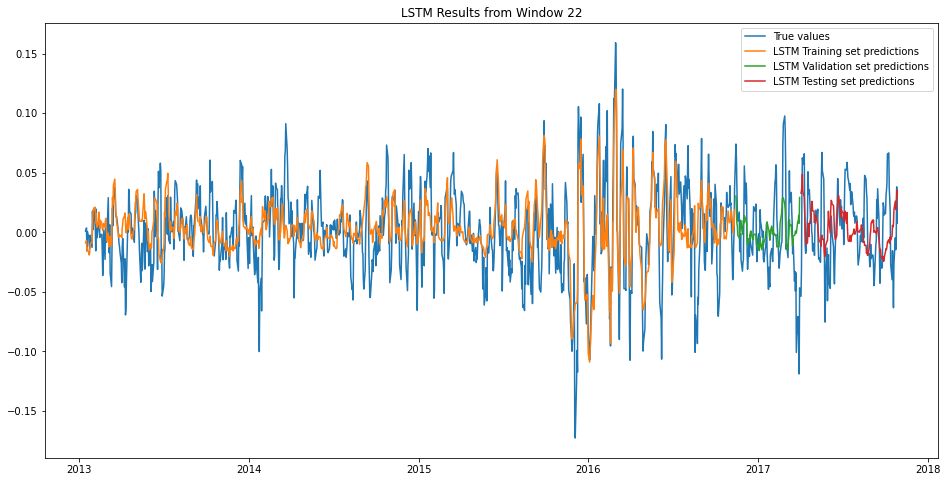

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.001420030427158948
RMSE = 0.03768329108715092
MAE = 0.027711321007694124
R-Squared = 0.00687931800063335

Results on Validation set: 
MSE = 0.000809215376561838
RMSE = 0.028446711173030846
MAE = 0.023863071343642295
R-Squared = -0.008608774516381645

Results on Testing set: 
MSE = 0.001576153108394112
RMSE = 0.039700794808090585
MAE = 0.029613369738794658
R-Squared = -0.07163716255146402



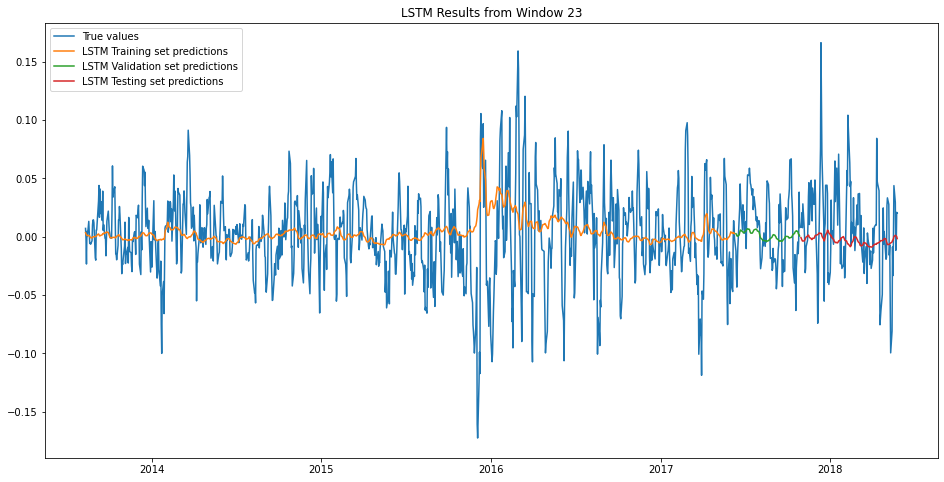

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0010014223825781472
RMSE = 0.03164525845333147
MAE = 0.023947011574704184
R-Squared = 0.33776566454267376

Results on Validation set: 
MSE = 0.0012636431910449423
RMSE = 0.03554775929710539
MAE = 0.02748255942474151
R-Squared = 0.012618176001237824

Results on Testing set: 
MSE = 0.0016859245810335191
RMSE = 0.041060011946339216
MAE = 0.03164858760649649
R-Squared = -0.06163909445222293



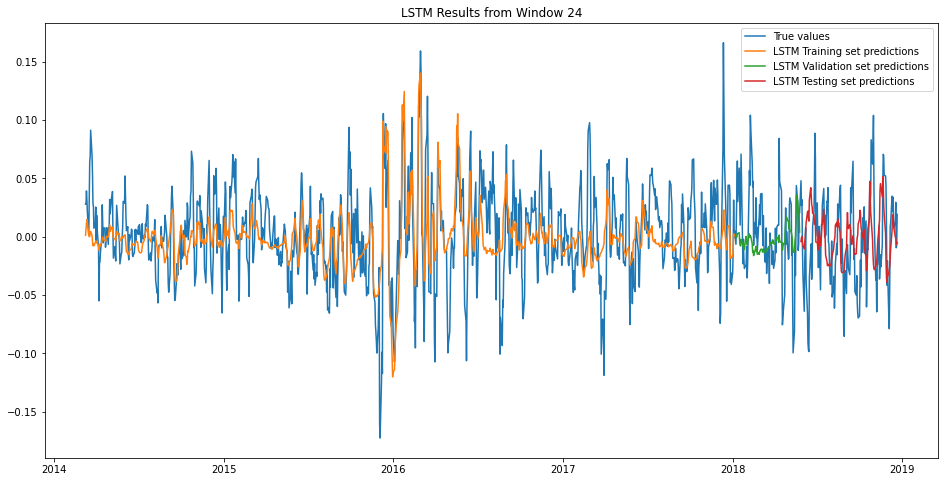

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4961

Results on Training set: 
MSE = 0.0014541691051372528
RMSE = 0.038133569268260906
MAE = 0.029445548744888916
R-Squared = 0.1085341962150933

Results on Validation set: 
MSE = 0.0013869720644676955
RMSE = 0.03724207384756783
MAE = 0.030089746187718834
R-Squared = 0.1315528645488534

Results on Testing set: 
MSE = 0.0009557199482192571
RMSE = 0.030914720574820937
MAE = 0.025424470182531005
R-Squared = 0.07120320625591536



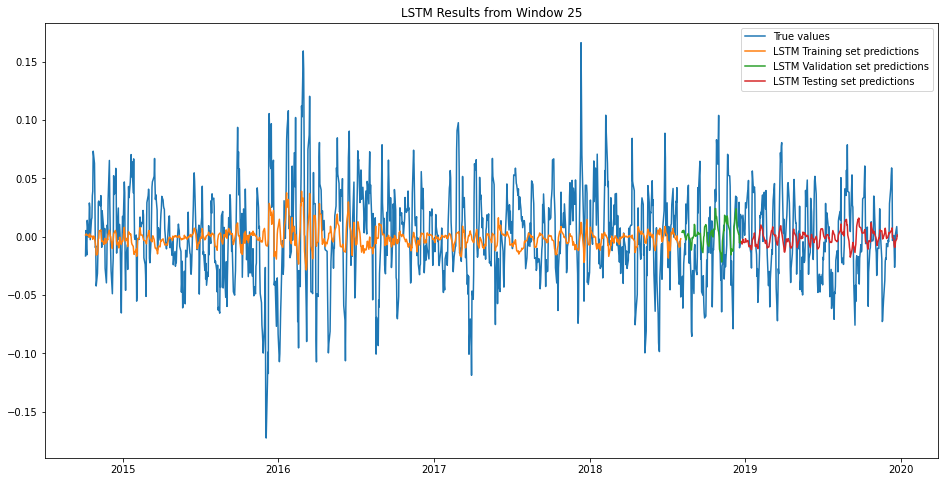

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 157
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.0032478259729254795
  dropout =  0.18163633650077912
  units = 256

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 17
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.000862928128902374
RMSE = 0.029375638357359554
MAE = 0.02261585182385797
R-Squared = 0.41055056481526164

Results on Validation set: 
MSE = 0.0011361732265677703
RMSE = 0.033707168771164545
MAE = 0.02729372534253808
R-Squared = 0.16487853542051456

Results on Testing set: 
MSE = 0.0010710744600951978
RMSE = 0.032727273948424083
MAE = 0.026536288925837946
R-Squared = -0.17070485867740604



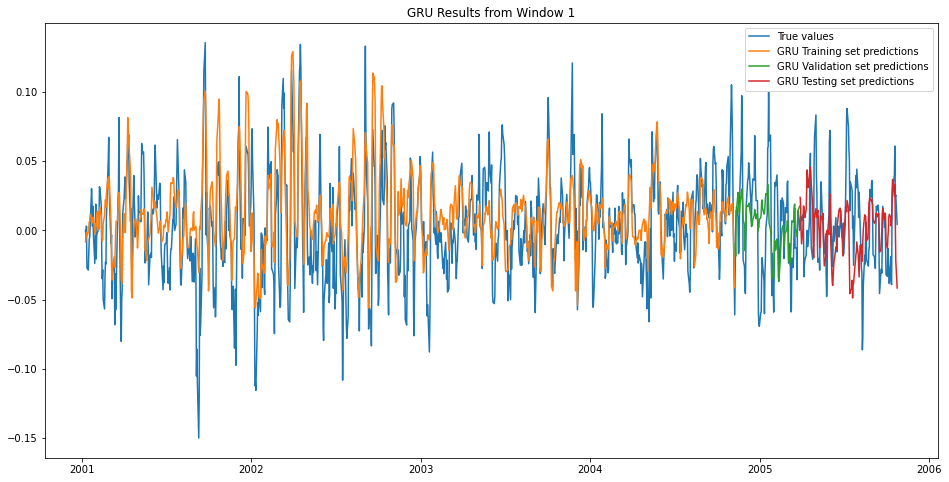

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0014448391723355918
RMSE = 0.038011040137512574
MAE = 0.029332217010695813
R-Squared = 0.03528869091291564

Results on Validation set: 
MSE = 0.0009003764970269325
RMSE = 0.03000627429433605
MAE = 0.02328711076448886
R-Squared = 0.01896301477660256

Results on Testing set: 
MSE = 0.00139772948503538
RMSE = 0.037386220523548244
MAE = 0.03124101264673411
R-Squared = -0.04590740391926995



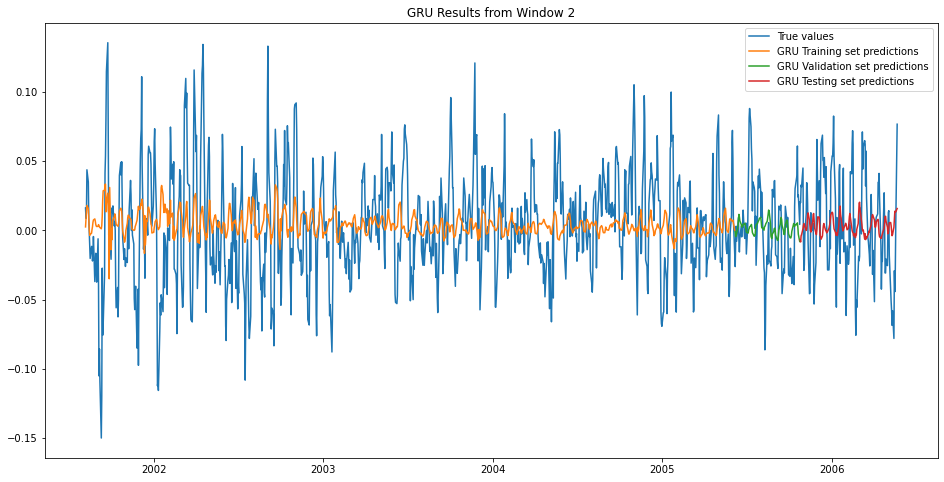

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0011939736519067728
RMSE = 0.03455392382793556
MAE = 0.026733316358621376
R-Squared = 0.05956587133816571

Results on Validation set: 
MSE = 0.001339977002817167
RMSE = 0.036605696316518374
MAE = 0.03020631685597426
R-Squared = 0.07668242822984128

Results on Testing set: 
MSE = 0.0015543144160080787
RMSE = 0.039424794432033235
MAE = 0.029054444245418167
R-Squared = 0.18904997209451446



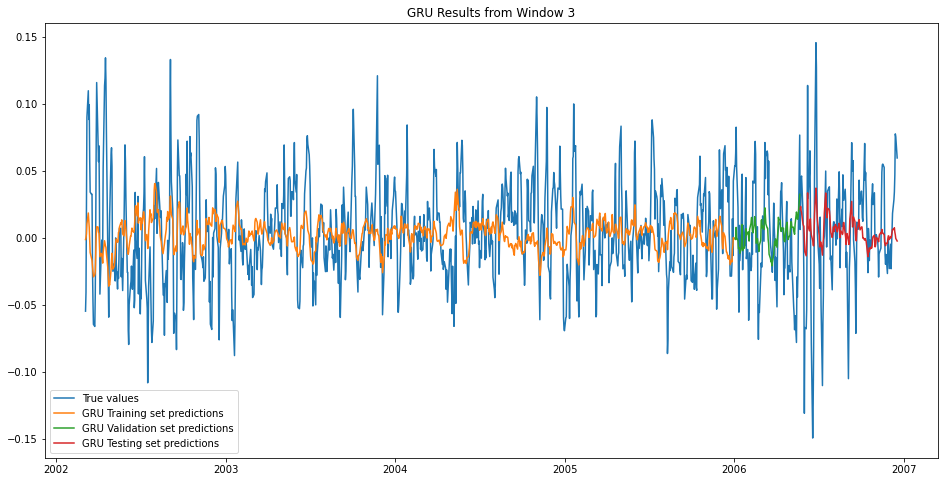

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0011926180721666868
RMSE = 0.03453430283307724
MAE = 0.027123986139865865
R-Squared = 0.018503743070871437

Results on Validation set: 
MSE = 0.0008013356660190513
RMSE = 0.02830787286284597
MAE = 0.02199732883458477
R-Squared = 0.18146422362879677

Results on Testing set: 
MSE = 0.001142507178204361
RMSE = 0.0338009937458111
MAE = 0.028345937607956995
R-Squared = 0.14447946520835242



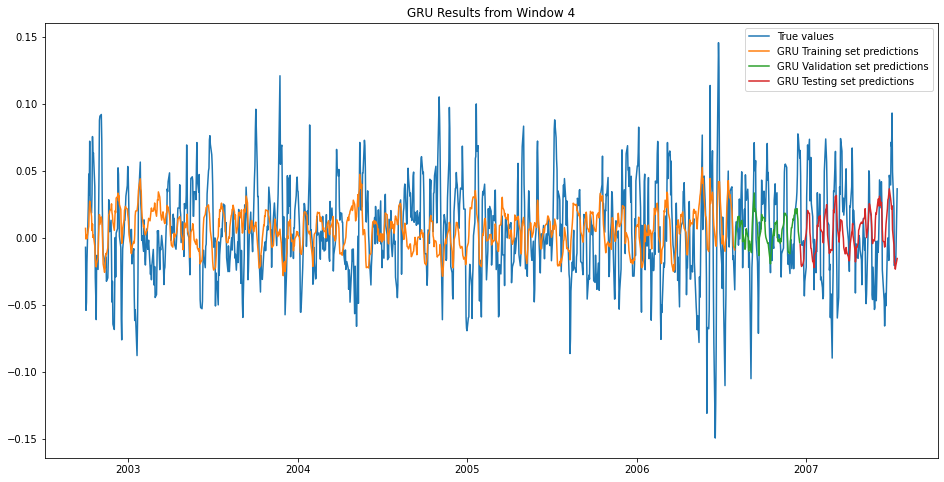

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0008584857796819203
RMSE = 0.02929992798083163
MAE = 0.02212913254342822
R-Squared = 0.29293136311719403

Results on Validation set: 
MSE = 0.001161353274830303
RMSE = 0.03407863369958225
MAE = 0.027799627308127753
R-Squared = 0.06597502963637358

Results on Testing set: 
MSE = 0.0023797324684861716
RMSE = 0.04878250166285214
MAE = 0.041078858721025305
R-Squared = -0.12511748030069691



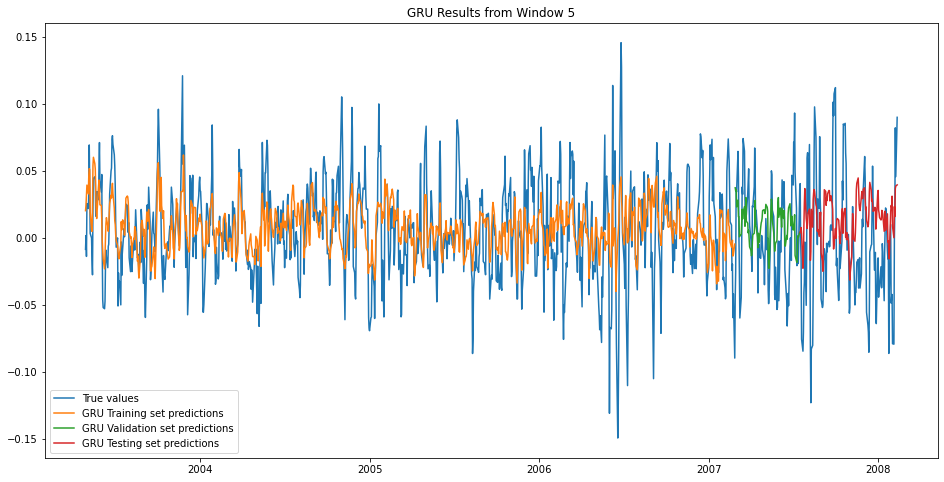

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.001208874125114119
RMSE = 0.0347688671819218
MAE = 0.02745175956307274
R-Squared = 0.07559611722708126

Results on Validation set: 
MSE = 0.002072291413885677
RMSE = 0.04552242759218446
MAE = 0.037375812138427375
R-Squared = -0.012384037474042264

Results on Testing set: 
MSE = 0.0023027069307294166
RMSE = 0.04798652863803983
MAE = 0.03729623038814688
R-Squared = -0.402138633732676



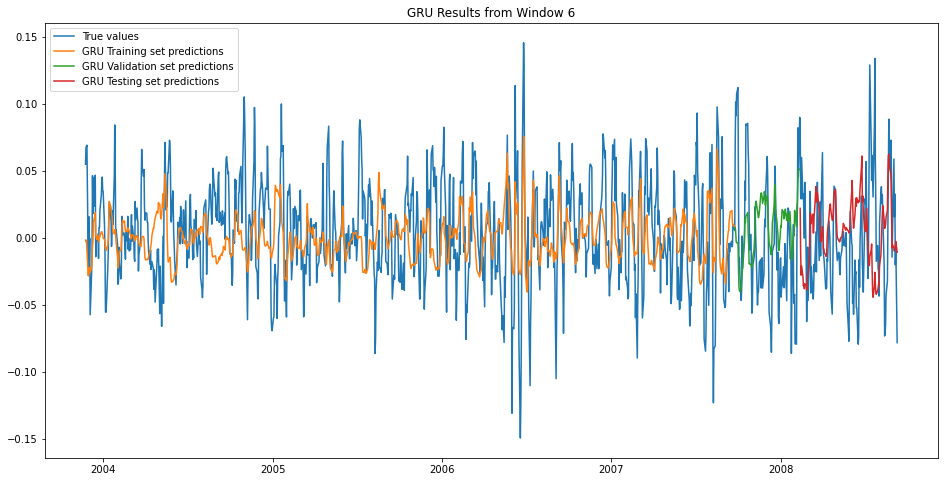

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0012689273288336315
RMSE = 0.03562200624380429
MAE = 0.02789952473538024
R-Squared = 0.11815947478714117

Results on Validation set: 
MSE = 0.0019124076812757568
RMSE = 0.04373108369656253
MAE = 0.034026032796544634
R-Squared = -0.0034028222024777843

Results on Testing set: 
MSE = 0.00541602331495126
RMSE = 0.07359363637537732
MAE = 0.05848054889429509
R-Squared = 0.009541720634365092



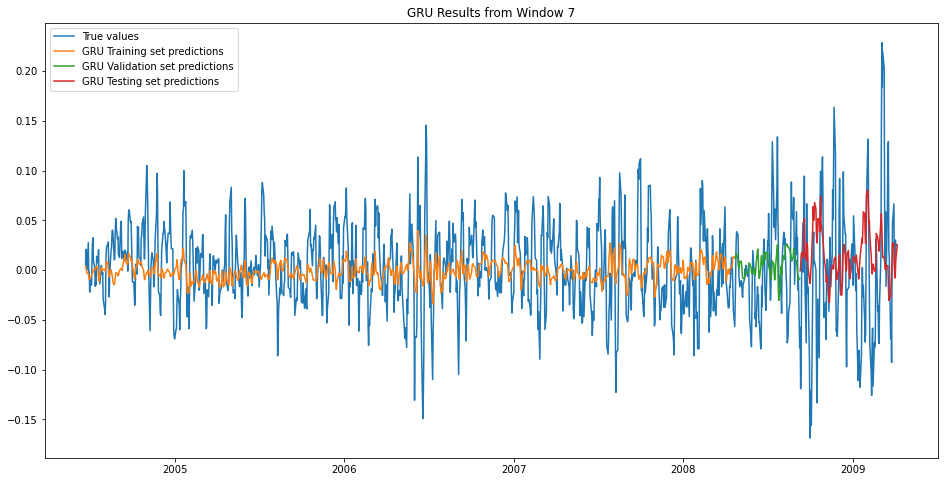

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0016670171642180528
RMSE = 0.04082912152150782
MAE = 0.03137461618549241
R-Squared = 0.0213740737917697

Results on Validation set: 
MSE = 0.005800935955338098
RMSE = 0.07616387565859617
MAE = 0.05769643103669049
R-Squared = -0.0017029959866341482

Results on Testing set: 
MSE = 0.0015856293198742537
RMSE = 0.03981996132436914
MAE = 0.03160732787442763
R-Squared = -0.08752983252846591



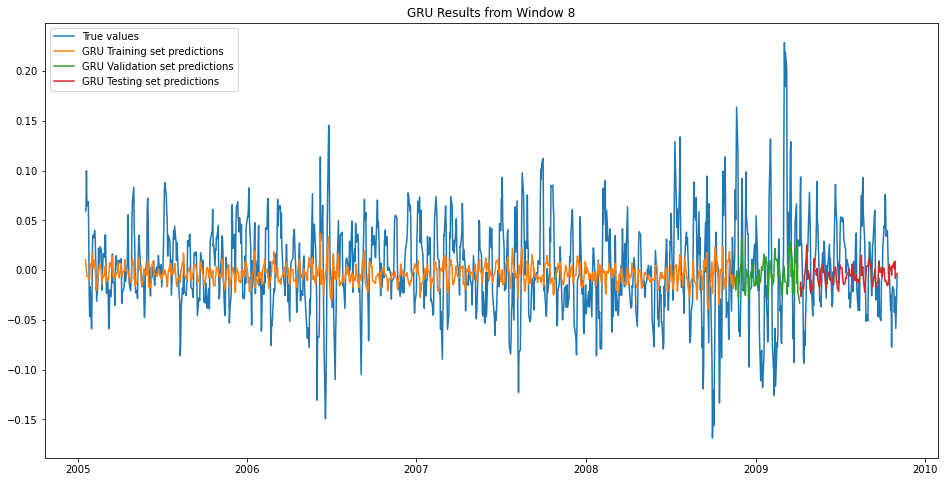

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.002056506579209973
RMSE = 0.045348721913742764
MAE = 0.034701450888831316
R-Squared = 0.06805706646039533

Results on Validation set: 
MSE = 0.0013163272963309463
RMSE = 0.03628122512169271
MAE = 0.02903911638996383
R-Squared = 0.015148841820343484

Results on Testing set: 
MSE = 0.0008483517601475629
RMSE = 0.029126478677443363
MAE = 0.022212250441113763
R-Squared = -0.16903299391515114



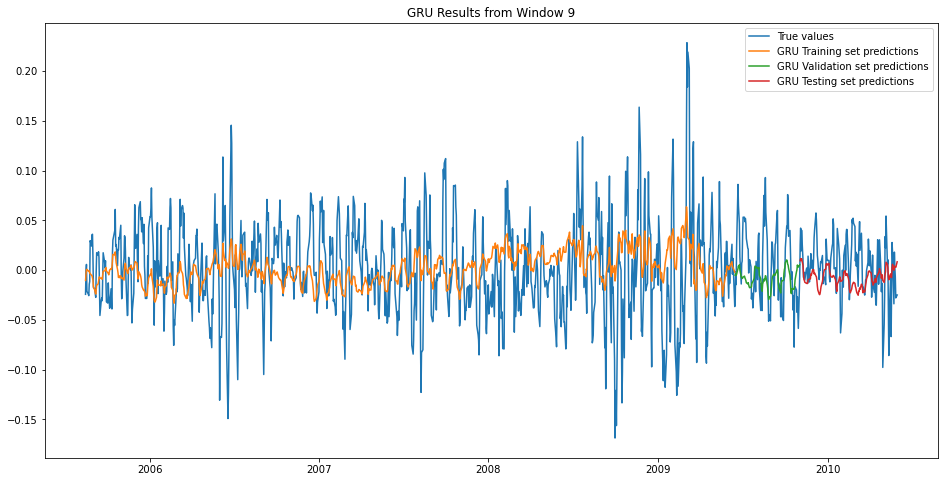

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0020648048064669812
RMSE = 0.04544012331042887
MAE = 0.03399941437245397
R-Squared = 0.05495792427762214

Results on Validation set: 
MSE = 0.0006767732330946265
RMSE = 0.026014865617462385
MAE = 0.020222995278111746
R-Squared = 0.2590054563511778

Results on Testing set: 
MSE = 0.0011729214883062417
RMSE = 0.03424794137325982
MAE = 0.028259627156474364
R-Squared = -0.5117422180480604



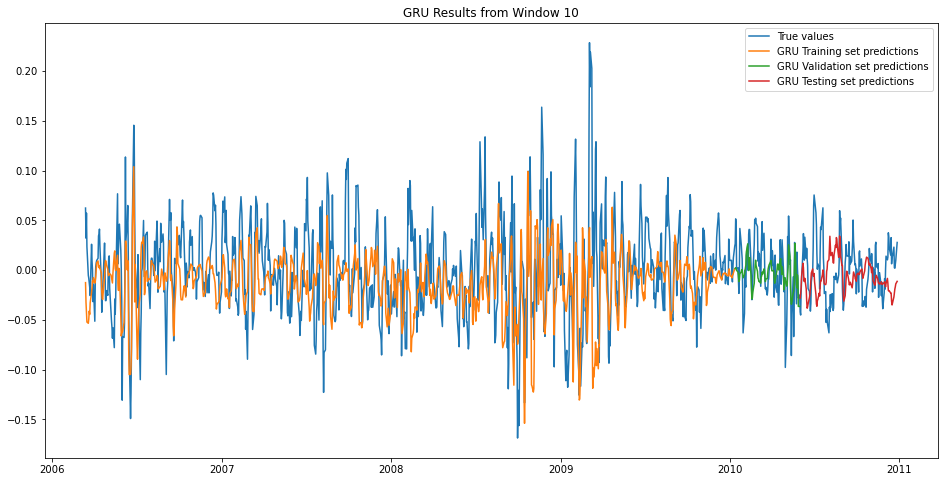

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0018457732541595317
RMSE = 0.04296246331577755
MAE = 0.03270869259142742
R-Squared = 0.09463407864410511

Results on Validation set: 
MSE = 0.0005752978094417851
RMSE = 0.023985366568843286
MAE = 0.018703068713234735
R-Squared = -0.15316696904307414

Results on Testing set: 
MSE = 0.0006491419670622954
RMSE = 0.025478264600680624
MAE = 0.021637619525595085
R-Squared = -0.22564020799728857



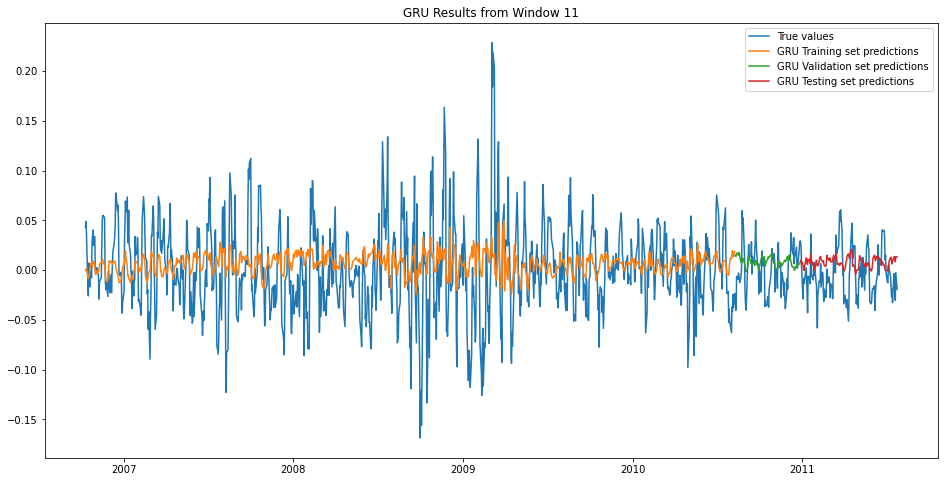

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.001838124560644984
RMSE = 0.04287335490307452
MAE = 0.0316487591297652
R-Squared = 0.047842647757659895

Results on Validation set: 
MSE = 0.0006741728015487232
RMSE = 0.02596483779168904
MAE = 0.021127221668505468
R-Squared = -0.09256494317752284

Results on Testing set: 
MSE = 0.0007226670666362716
RMSE = 0.0268824676441035
MAE = 0.021328641600410772
R-Squared = -0.006055174195035651



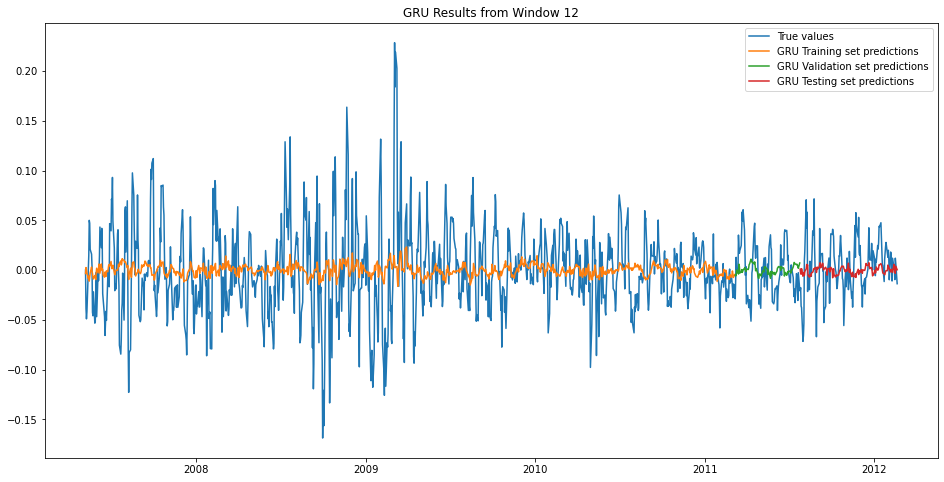

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0017644414473153775
RMSE = 0.04200525499643321
MAE = 0.031781990271707014
R-Squared = -0.006863987345941069

Results on Validation set: 
MSE = 0.00034001172703317805
RMSE = 0.01843940690567834
MAE = 0.014456875780283858
R-Squared = 0.26073329611653584

Results on Testing set: 
MSE = 0.0007409247355065885
RMSE = 0.027219932687400028
MAE = 0.020404419221851804
R-Squared = -0.2333816591811635



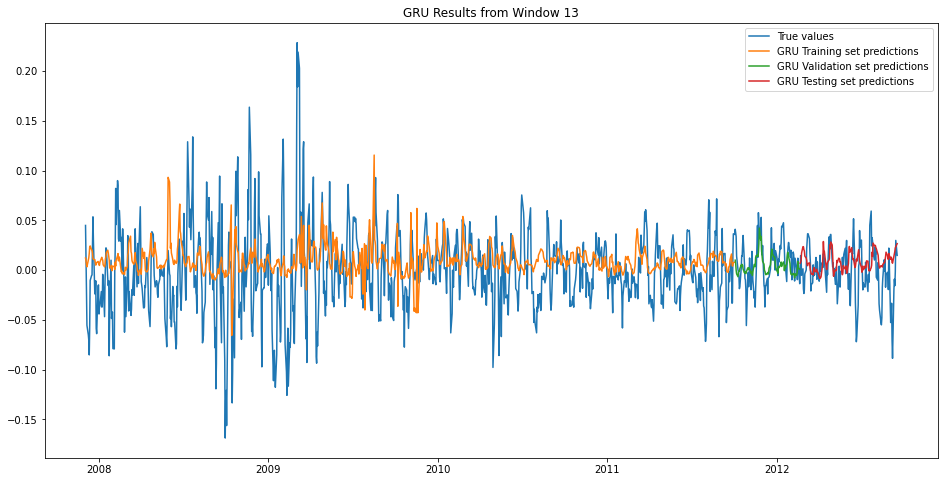

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0008493842754032511
RMSE = 0.029144197971521728
MAE = 0.022164708403514113
R-Squared = 0.47211954758206587

Results on Validation set: 
MSE = 0.0006903999272817369
RMSE = 0.026275462456096504
MAE = 0.01924237364568136
R-Squared = 0.04820892345633376

Results on Testing set: 
MSE = 0.0006863522052999876
RMSE = 0.02619832447504969
MAE = 0.01987239587066244
R-Squared = -0.31987915856058624



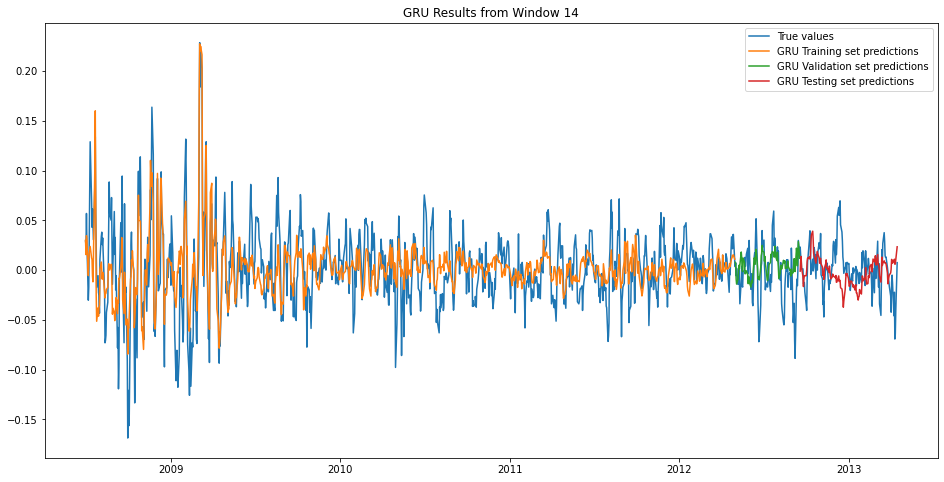

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0016240513021960946
RMSE = 0.04029951987550341
MAE = 0.027979723031112295
R-Squared = -0.4282374604789292

Results on Validation set: 
MSE = 0.0005675149729230673
RMSE = 0.023822572760368838
MAE = 0.0174510521958456
R-Squared = 0.03810013535479406

Results on Testing set: 
MSE = 0.0005402591586145387
RMSE = 0.02324347561391236
MAE = 0.01873741272973777
R-Squared = -0.05289709097869655



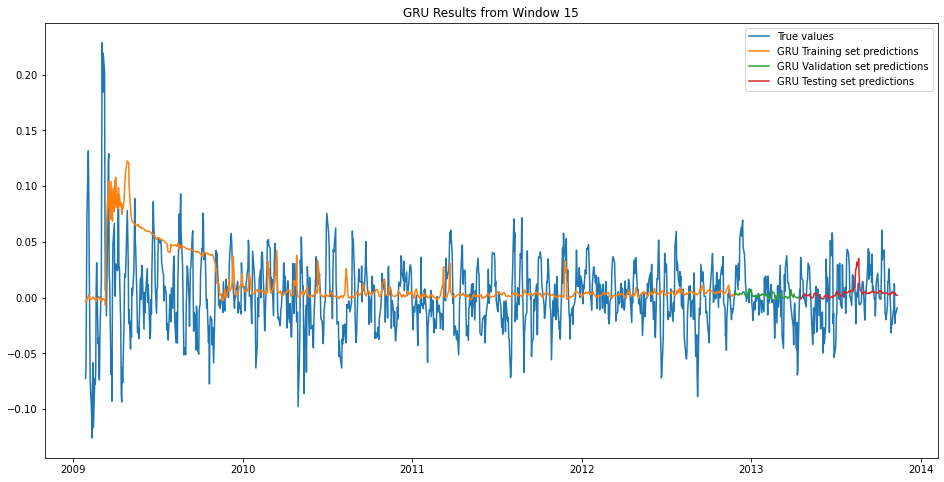

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.00016994454396130297
RMSE = 0.013036277994937933
MAE = 0.0100501326624769
R-Squared = 0.7500368016233427

Results on Validation set: 
MSE = 0.00033771954267606353
RMSE = 0.018377147294290904
MAE = 0.013947377172127415
R-Squared = 0.257336458033923

Results on Testing set: 
MSE = 0.001893364340052546
RMSE = 0.043512806621183904
MAE = 0.03318520132919269
R-Squared = -1.3593596102962011



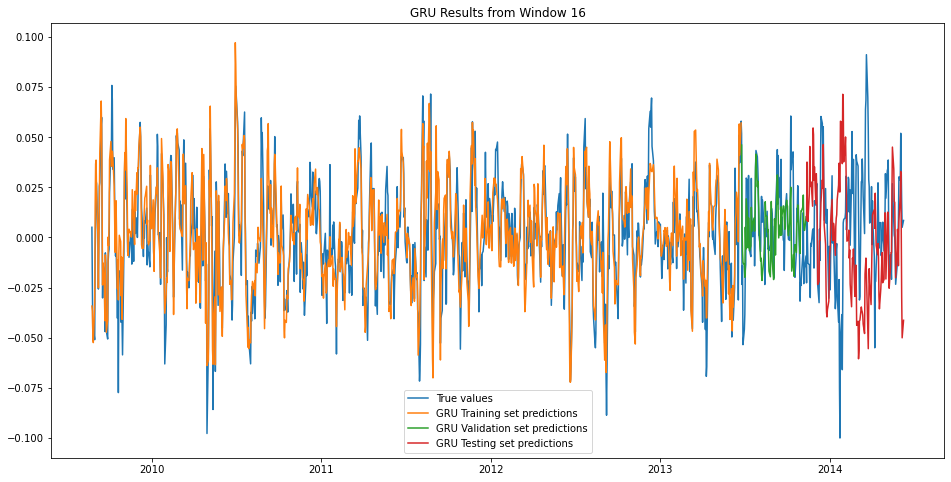

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0008318985568880896
RMSE = 0.02884265169654291
MAE = 0.022426657443314194
R-Squared = -0.3161103745467564

Results on Validation set: 
MSE = 0.0009893861383955408
RMSE = 0.031454509031227
MAE = 0.02254127972802232
R-Squared = -0.10194368817313948

Results on Testing set: 
MSE = 0.0007962184818522977
RMSE = 0.02821734363564894
MAE = 0.02230734818488614
R-Squared = -0.2624716089647059



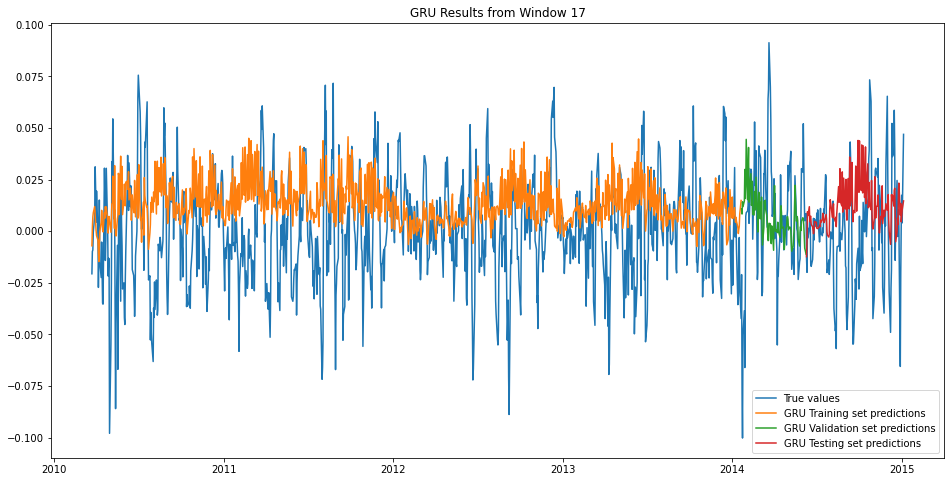

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0005890668543410858
RMSE = 0.0242706995025089
MAE = 0.018699015584425976
R-Squared = 0.012997765618988688

Results on Validation set: 
MSE = 0.0007452673797601434
RMSE = 0.027299585706749167
MAE = 0.021221125143752958
R-Squared = 0.06117848409075177

Results on Testing set: 
MSE = 0.0008338156249287276
RMSE = 0.028875865786651793
MAE = 0.023217052146022047
R-Squared = -0.005055292114675147



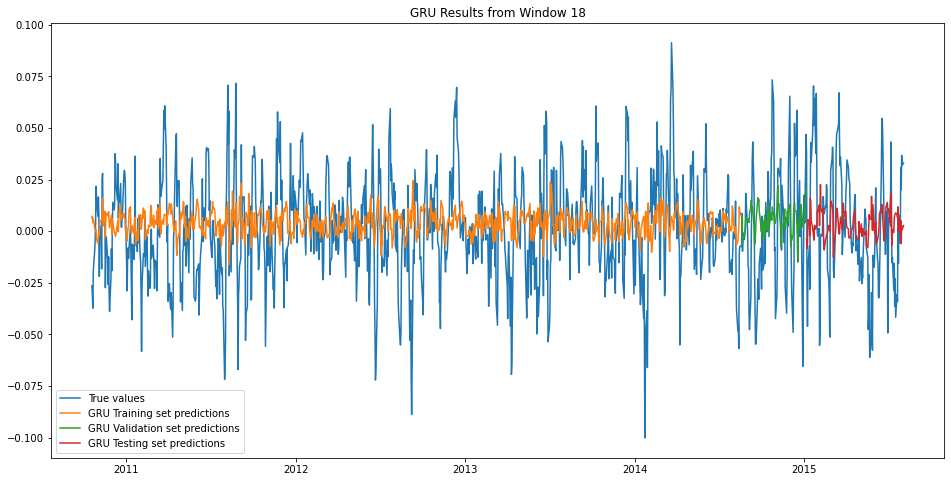

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0004677800006987436
RMSE = 0.021628222319431237
MAE = 0.016383050062745704
R-Squared = 0.2862825339191555

Results on Validation set: 
MSE = 0.0006238276850321455
RMSE = 0.024976542695740445
MAE = 0.019944741907108234
R-Squared = 0.056159391660271285

Results on Testing set: 
MSE = 0.0041158112979141365
RMSE = 0.0641545890635591
MAE = 0.04953081480000813
R-Squared = -0.35900691658691075



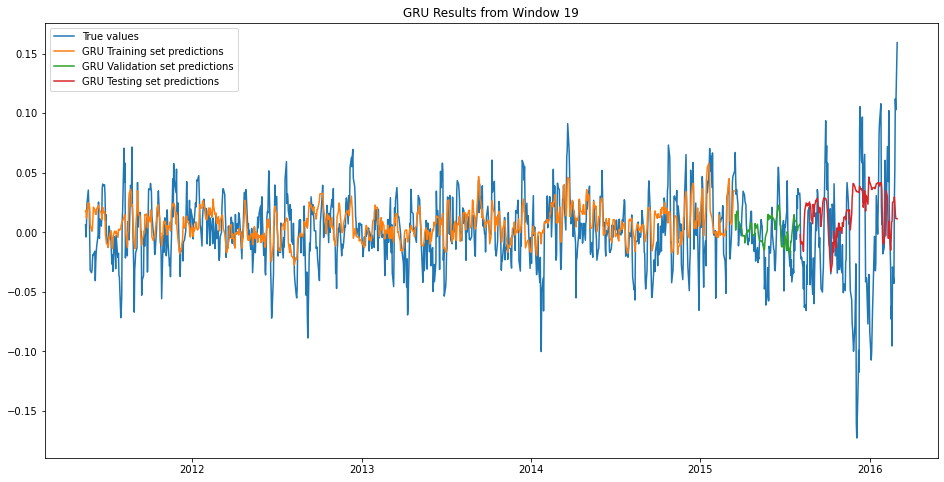

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0011082301193672732
RMSE = 0.033290090407916785
MAE = 0.026697612172359178
R-Squared = -0.6342081367622028

Results on Validation set: 
MSE = 0.003825842555053571
RMSE = 0.06185339566308038
MAE = 0.048022996657085336
R-Squared = 0.015559701526745351

Results on Testing set: 
MSE = 0.002590623348076936
RMSE = 0.05089816645103177
MAE = 0.041198476527351355
R-Squared = -0.09407616320240142



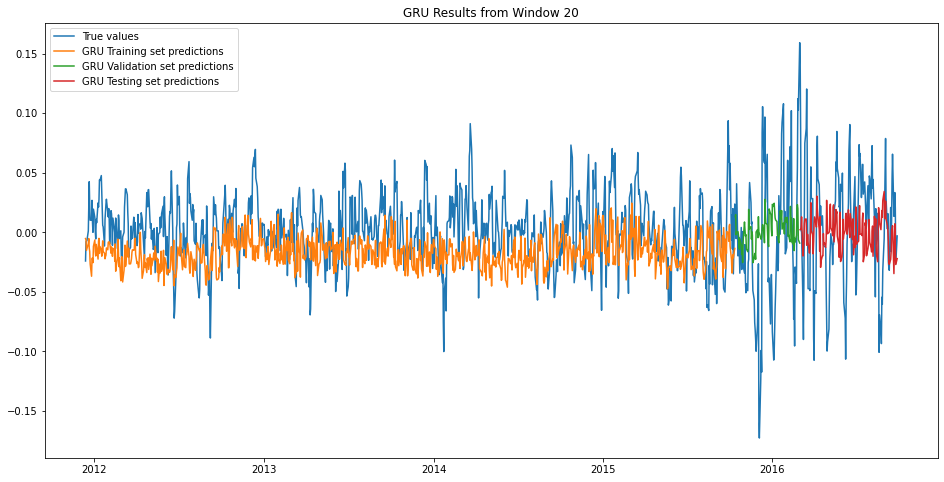

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.001149287973727083
RMSE = 0.03390115003546462
MAE = 0.02499990360648301
R-Squared = 0.02470278943794646

Results on Validation set: 
MSE = 0.001956850506014322
RMSE = 0.04423630303285212
MAE = 0.03583852212593146
R-Squared = -0.04809736205622217

Results on Testing set: 
MSE = 0.0014097341332272321
RMSE = 0.0375464263709242
MAE = 0.02876180691397029
R-Squared = -0.0723057115454544



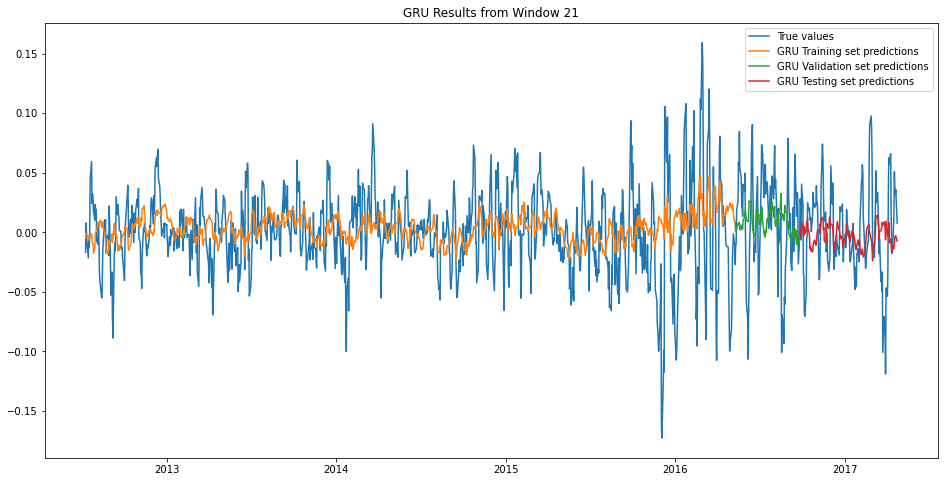

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0011832497303058656
RMSE = 0.03439839720547842
MAE = 0.025536332317169255
R-Squared = 0.10995828005775987

Results on Validation set: 
MSE = 0.0014123450540355703
RMSE = 0.03758117951895031
MAE = 0.0275841589714899
R-Squared = 0.042316606374115606

Results on Testing set: 
MSE = 0.0008931154276517399
RMSE = 0.029885036852106105
MAE = 0.02410356832622474
R-Squared = -0.07801769976618678



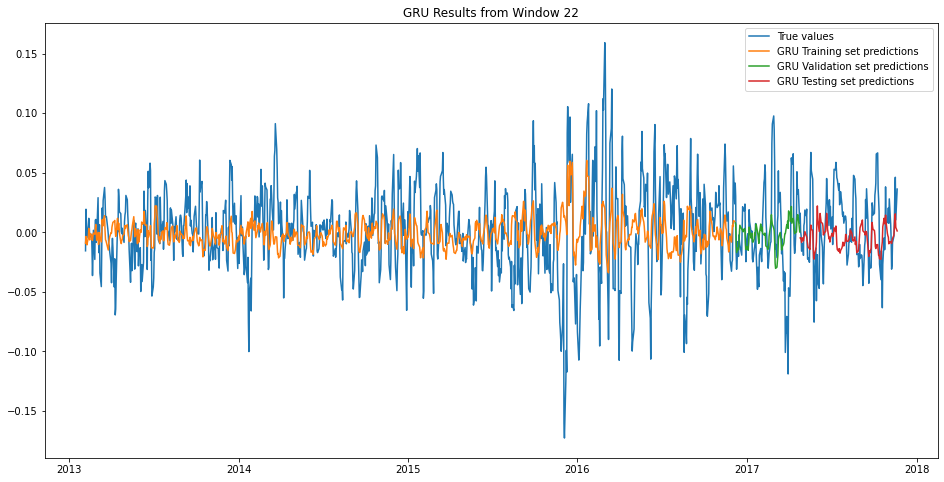

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0013025517641551603
RMSE = 0.03609088200855114
MAE = 0.026218620357111116
R-Squared = 0.09401067514914885

Results on Validation set: 
MSE = 0.0007783265532440061
RMSE = 0.027898504498341952
MAE = 0.023440220465019194
R-Squared = 0.001155814632223251

Results on Testing set: 
MSE = 0.0020283100452326676
RMSE = 0.04503676326327934
MAE = 0.03447452323542845
R-Squared = -0.15563071116846205



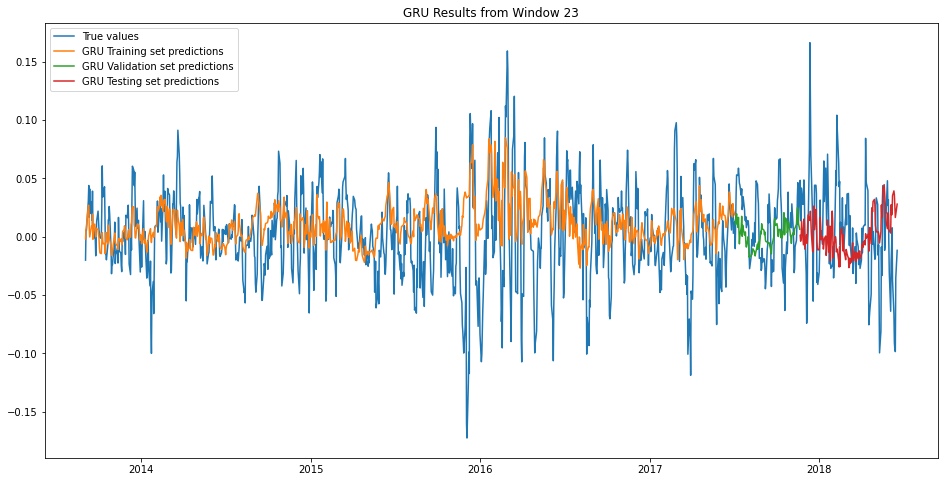

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0013812057318070593
RMSE = 0.037164576303343744
MAE = 0.028171712597605564
R-Squared = 0.08045583583232752

Results on Validation set: 
MSE = 0.0014267076525587884
RMSE = 0.03777178381489003
MAE = 0.029047454879998144
R-Squared = 0.06182180195478382

Results on Testing set: 
MSE = 0.0013341420514723958
RMSE = 0.0365259093175296
MAE = 0.029126147658201217
R-Squared = 0.03381286426274788



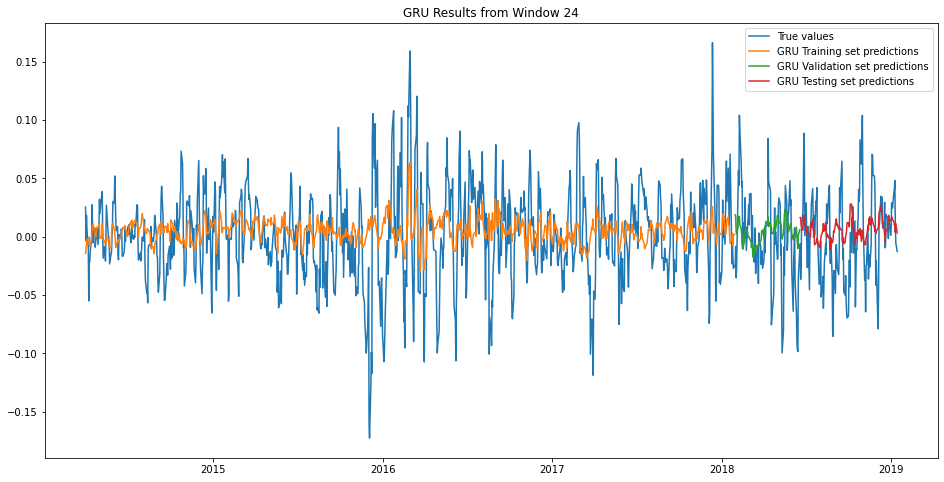

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4945

Results on Training set: 
MSE = 0.0015851940048479376
RMSE = 0.039814494908863754
MAE = 0.030628729429189035
R-Squared = 0.02994121770848346

Results on Validation set: 
MSE = 0.0013915427786801435
RMSE = 0.037303388300262266
MAE = 0.030456539986479077
R-Squared = 0.10170095143840951

Results on Testing set: 
MSE = 0.0010448103248005749
RMSE = 0.0323235258720421
MAE = 0.02682383212226142
R-Squared = 0.01025839181273791



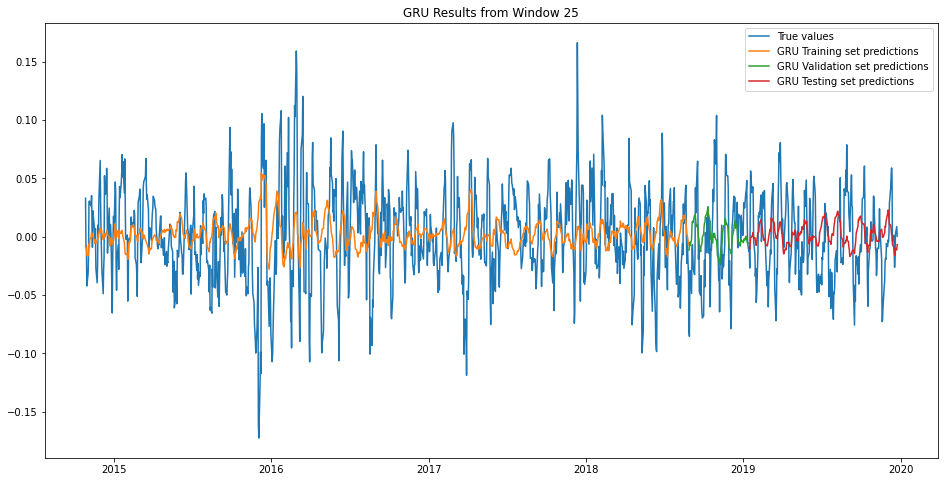

In [10]:
#Declaring model parameters
sequencelength = 173
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.0015091965258561396
RMSE = 0.03884837867731599
MAE = 0.029106537742827683
R-Squared = -0.08896253837544621

GRU model results on the Testing set
MSE = 0.0015530015459453677
RMSE = 0.03940814060502434
MAE = 0.029874767537109277
R-Squared = -0.11841009440230477

Naive model results on the Testing set
MSE = 0.0032690037923252236
RMSE = 0.057175202599774176
MAE = 0.04297518318087576
R-Squared = -1.3549373296170169

Drift model results on the Testing set
MSE = 0.003951177701140702
RMSE = 0.06285839403882908
MAE = 0.0467123277104984
R-Squared = -1.846364353021492



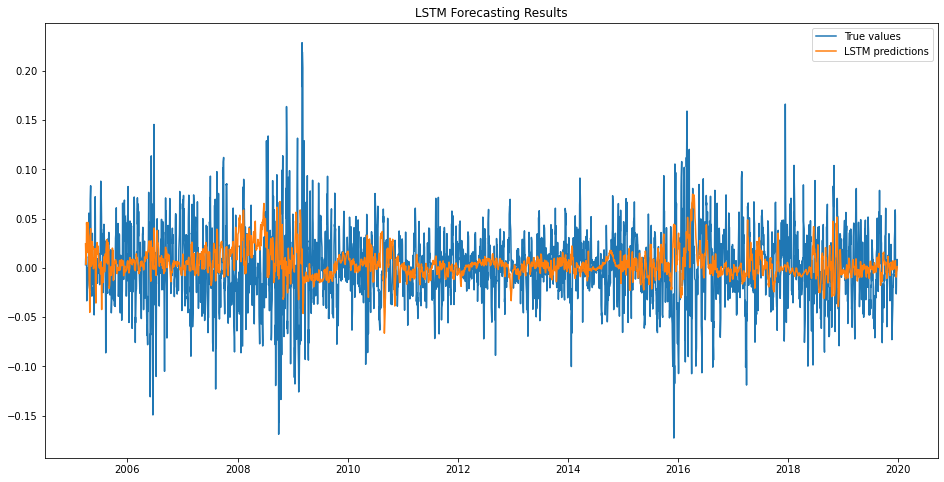

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

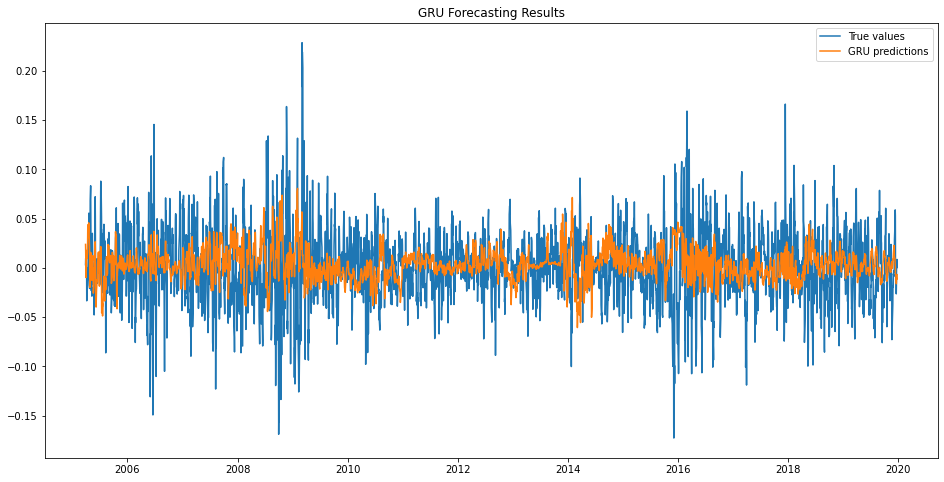

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

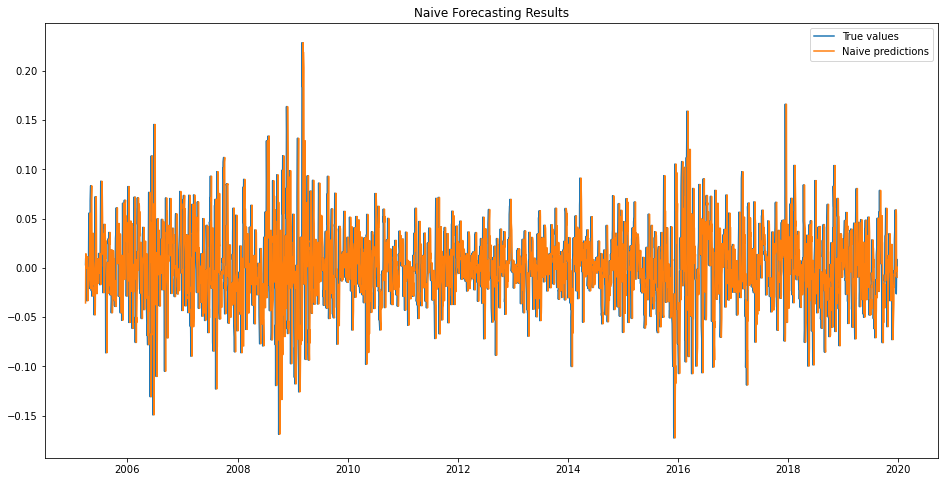

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

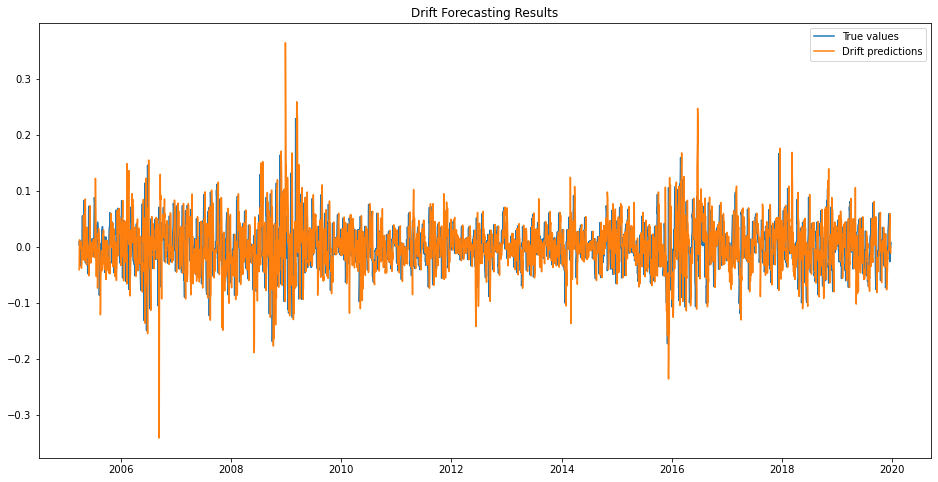

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['SBK LSTM'] = lstm_predictions[-numpreds:]
savePredictions['SBK GRU'] = gru_predictions[-numpreds:]
savePredictions['SBK Naive'] = naive_predictions[-numpreds:]
savePredictions['SBK Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./SBK_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

SBK LSTM   SBK GRU  SBK Naive  SBK Drift
Date                                                
2005-03-29  0.024470  0.023867  -0.035545  -0.040870
2005-03-30  0.017210  0.017129  -0.003231  -0.006301
2005-03-31  0.003447 -0.000684   0.014094   0.012220
2005-04-01  0.007406 -0.009714   0.014412   0.012583
2005-04-04  0.027031  0.000879   0.000000  -0.002740